In [40]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o")

In [41]:
class Ingredient(BaseModel):

    name: str
    quantity: str
    unit: str


class IngredientsOutput(BaseModel):

    ingredients: list[Ingredient]


class State(TypedDict):

    dish: str
    ingredients: list[Ingredient]
    recipe_steps: str
    plating_instructions: str

In [42]:
def list_ingredients(state: State):
    structured_llm = llm.with_structured_output(IngredientsOutput)
    response = structured_llm.invoke(
        f"List 5-8 ingredients needed to make {state['dish']}"
    )
    return {"ingredients": response.ingredients}


def create_recipe(state: State):
    response = llm.invoke(
        f"Write a step by step cooking intruction for {state['dish']}, using these ingredients {state['ingredients']}"
    )

    return {"recipe_steps": response.content}


def describe_plating(state: State):
    response = llm.invoke(
        f"Describe how to beautifully plate this dish {state['dish']} based on this recipe {state['recipe_steps']}"
    )

    return {"plating_instructions": response.content}


def gate(state: State):

    ingredients = state["ingredients"]

    if 3 < len(ingredients) < 8:
        return False

    return True

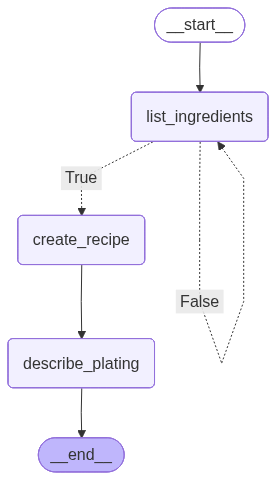

In [43]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)

graph_builder.add_edge(START, "list_ingredients")
graph_builder.add_conditional_edges(
    "list_ingredients", gate, {True: "create_recipe", False: "list_ingredients"}
)
graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", END)

graph = graph_builder.compile()

graph

In [44]:
graph.invoke({"dish": "hummus"})

{'dish': 'hummus',
 'ingredients': [Ingredient(name='Chickpeas', quantity='1', unit='can (15 oz)'),
  Ingredient(name='Tahini', quantity='1/4', unit='cup'),
  Ingredient(name='Lemon juice', quantity='2', unit='tablespoons'),
  Ingredient(name='Olive oil', quantity='1', unit='tablespoon'),
  Ingredient(name='Garlic cloves', quantity='2', unit='medium, minced'),
  Ingredient(name='Cumin', quantity='1', unit='teaspoon'),
  Ingredient(name='Salt', quantity='to taste', unit='none'),
  Ingredient(name='Water', quantity='2-4', unit='tablespoons')],
 'recipe_steps': "Here's a simple step-by-step guide to making delicious hummus using the ingredients you provided:\n\n### Ingredients:\n- 1 can (15 oz) of chickpeas\n- 1/4 cup of tahini\n- 2 tablespoons of lemon juice\n- 1 tablespoon of olive oil\n- 2 medium garlic cloves, minced\n- 1 teaspoon of cumin\n- Salt to taste\n- 2-4 tablespoons of water\n\n### Instructions:\n\n1. **Prepare the Chickpeas:**\n   - Open the can of chickpeas and drain them i